Deep Q Learning with an Alternative Game Environment. 
Users are able to bet money now

In [1]:
from collections import defaultdict
import numpy as np 
import random
import gymnasium as gym
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, input_dim=4, output_dim=2):  # 2 actions: hit or stick
        super(QNetwork, self).__init__()

        self.fnn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        out = self.fnn(x)
        return out

In [ ]:
import numpy as np 

class BettingBlackjackEnv:
    def __init__(self, base_env, starting_money=100):
        self.env = base_env
        self.starting_money = starting_money
        self.reset()

    def reset(self):
        self.money = self.starting_money
        self.current_bet = 5  # default
        obs, info = self.env.reset()
        return obs, info

    def step(self, action):
        obs, reward, termination, truncated, info = self.env.step(action)

        # Scale reward by current bet
        scaled_reward = reward * self.current_bet
        self.money += scaled_reward

        return obs, scaled_reward, termination, truncated, info

    def place_bet(self, bet_amount):
        self.current_bet = int(np.clip(bet_amount, 5, min(100, self.money)))


In [10]:
import random 

def choose_bet(agent_money):
    return random.choice([5, 10, 20, 50, 100]) if agent_money >= 5 else 0


In [25]:
import torch
import torch.nn as nn
import numpy as np
import random


class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class Agent:
    def __init__(self, params):
        self.params = params
        self.bet_options = [5, 10, 20, 50, 100]

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Q-network for playing (hit/stand)
        self.q_net = QNetwork(3, 2).to(self.device)

        # Q-network for betting (predict best bet size)
        self.bet_q_net = QNetwork(3, len(self.bet_options)).to(self.device)

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(
            list(self.q_net.parameters()) + list(self.bet_q_net.parameters()),
            lr=self.params['lr']
        )

    def tensor(self, obs):
        return torch.FloatTensor(obs).to(self.device)

    @torch.no_grad()
    def greedy_action(self, obs):
        """ Epsilon-greedy policy for action selection (hit/stand) """
        if np.random.random() < self.params['e']:
            return random.choice([0, 1])
        else:
            obs_tensor = self.tensor(obs)
            q_values = self.q_net(obs_tensor)
            return torch.argmax(q_values).item()

    @torch.no_grad()
    def greedy_bet(self, obs):
        """ Epsilon-greedy policy for bet selection """
        if np.random.random() < self.params['e']:
            return random.choice(self.bet_options)
        else:
            obs_tensor = self.tensor(obs)
            q_values = self.bet_q_net(obs_tensor)
            best_idx = torch.argmax(q_values).item()
            return self.bet_options[best_idx]

    def decay(self):
        self.params['e'] = max(0.01, self.params['e'] - 0.001)

    def update(self, current_state, next_state, reward, action, termination, bet):
        """ Update both Q-networks (play and bet) """
        state_tensor = self.tensor(current_state)
        q_values = self.q_net(state_tensor)
        current_q = q_values[action]

        with torch.no_grad():
            next_tensor = self.tensor(next_state)
            next_q = torch.max(self.q_net(next_tensor))
            td_target = reward + self.params['discount'] * next_q * (1 - int(termination))

        loss = self.criterion(current_q, td_target)

        # Update bet Q-network
        bet_q_values = self.bet_q_net(state_tensor)
        bet_index = self.bet_options.index(bet)
        current_bet_q = bet_q_values[bet_index]

        with torch.no_grad():
            # Use same reward as feedback for bet learning
            bet_td_target = reward

        bet_loss = self.criterion(current_bet_q, torch.tensor(bet_td_target).to(self.device))

        total_loss = loss + bet_loss

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        self.decay()

        return total_loss.item()

    def generate_q_table(self, usable_ace=False):
        """Generate a tabular Q-value dict for hit/stand policy"""
        self.q_values = {}
        for player_sum in range(12, 22):
            for dealer_card in range(1, 11):
                state = (player_sum, dealer_card, usable_ace)
                state_tensor = self.tensor(state)
                with torch.no_grad():
                    q_vals = self.q_net(state_tensor)
                self.q_values[state] = q_vals.cpu().numpy()

    def generate_bet_table(self, usable_ace=False):
        """Generate a betting policy dict based on learned Q-values"""
        self.bet_values = {}
        for player_sum in range(12, 22):
            for dealer_card in range(1, 11):
                state = (player_sum, dealer_card, usable_ace)
                obs = self.tensor(state)
                with torch.no_grad():
                    q_vals = self.bet_q_net(obs)
                best_idx = torch.argmax(q_vals).item()
                best_bet = self.bet_options[best_idx]
                self.bet_values[state] = best_bet

    def get_bet_grid(self, usable_ace=False):
        """Return a NumPy grid (dealer on Y, player sum on X) of best bets"""
        self.generate_bet_table(usable_ace)
        grid = np.zeros((10, 10))
        for i, dealer_card in enumerate(range(1, 11)):
            for j, player_sum in enumerate(range(12, 22)):
                state = (player_sum, dealer_card, usable_ace)
                grid[i, j] = self.bet_values.get(state, 0)
        return grid


In [30]:
params = {'discount': 0.6, 'lr': 0.001, 'e': 0.05}
agent = Agent(params)
losses = []
env = gym.make("Blackjack-v1")
env = BettingBlackjackEnv(base_env=env)  # wrap original env

episode_rewards = []
episode_bets = []
agent_money = []

for episode in range(20_000):
    obs, _ = env.reset()

    # Agent chooses bet BEFORE seeing cards
    bet = agent.greedy_bet([0, 0, 0])  # dummy input since no cards yet
    env.place_bet(bet)

    done = False
    episode_reward = 0

    while not done:
        action = agent.greedy_action(obs)
        next_obs, reward, termination, truncated, info = env.step(action)

        done = termination or truncated

        # Update both Q-networks (play and bet)
        loss = agent.update(obs, next_obs, reward, action, termination, bet)

        obs = next_obs
        episode_reward += reward

    # Log this episode
    episode_rewards.append(episode_reward)
    episode_bets.append(bet)
    agent_money.append(env.money)  # total money after episode



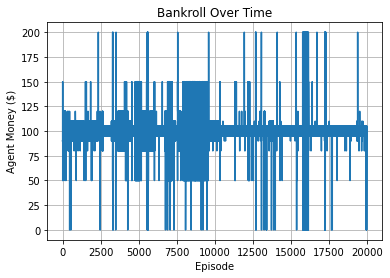

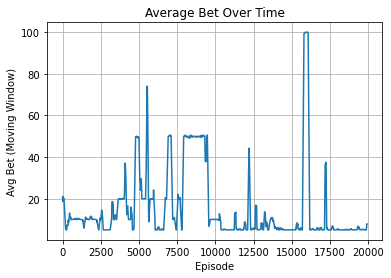

In [31]:
import matplotlib.pyplot as plt

# Plot bankroll over time
plt.plot(agent_money)
plt.xlabel("Episode")
plt.ylabel("Agent Money ($)")
plt.title("Bankroll Over Time")
plt.grid(True)
plt.show()

# Optional: Average bet over time
plt.plot(np.convolve(episode_bets, np.ones(100)/100, mode='valid'))
plt.xlabel("Episode")
plt.ylabel("Avg Bet (Moving Window)")
plt.title("Average Bet Over Time")
plt.grid(True)
plt.show()
